<a href="https://colab.research.google.com/github/Rashimanish/USA-Flight-Prediction/blob/main/Google%20Colab/Experiment_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.2 MB/s eta 0:00:00


In [ ]:
#import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import catboost as cat

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# File path
file_path = '/content/drive/My Drive/Cleaned_Data/dataset09.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
df.shape

(1802634, 24)

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DISTANCE,ORIGIN_CARRIER,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,Maximum temperature,Minimum temperature,Precipitation,Snowfall,Average wind speed
0,2022,1,1,1,2022-01-01,10397,ATL,11057,CLT,226,DL,645,640.0,0.0,0.0,809,751.0,0.0,0.0,78,68,0.06,0.0,11.86
1,2022,1,1,1,2022-01-01,13204,MCO,13930,ORD,1005,SW,1429,1423.0,0.0,0.0,1639,1611.0,0.0,0.0,84,65,0.00,0.0,7.61
2,2022,1,1,1,2022-01-01,13204,MCO,13930,ORD,1005,SW,1210,1204.0,0.0,0.0,1419,1348.0,0.0,0.0,84,65,0.00,0.0,7.61
3,2022,1,1,1,2022-01-01,13204,MCO,13930,ORD,1005,SW,1117,1109.0,0.0,0.0,1320,1303.0,0.0,0.0,84,65,0.00,0.0,7.61
4,2022,1,1,1,2022-01-01,13204,MCO,13930,ORD,1005,SW,1010,1100.0,50.0,1.0,1200,1307.0,67.0,1.0,84,65,0.00,0.0,7.61


In [ ]:
unique_values_df = pd.DataFrame({
    'Column': df.columns,
     'Count of Unique Values': [len(df[col].unique()) for col in df.columns],
    'Unique Values': [df[col].unique() for col in df.columns]
})
unique_values_df

,Column,Count of Unique Values,Unique Values
0,YEAR,2,"[2022, 2023]"
1,QUARTER,4,"[1, 2, 3, 4]"
2,MONTH,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
3,DAY_OF_MONTH,31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,FL_DATE,730,"[2022-01-01, 2022-01-02, 2022-01-03, 2022-01-0..."
5,ORIGIN_AIRPORT_ID,15,"[10397, 13204, 13303, 13930, 12892, 12889, 147..."
6,ORIGIN,15,"[ATL, MCO, MIA, ORD, LAX, LAS, SEA, PHX, SFO, ..."
7,DEST_AIRPORT_ID,15,"[11057, 13930, 13303, 12892, 12889, 10397, 147..."
8,DEST,15,"[CLT, ORD, MIA, LAX, LAS, ATL, SFO, SEA, PHX, ..."
9,DISTANCE,103,"[226, 1005, 192, 2218, 2039, 594, 2446, 2554, ..."


In [ ]:
def drop_cols(df):
    columns_to_drop = [
        'YEAR',
        'QUARTER',
        'DEP_TIME',
        'ARR_TIME',
        'DEP_DEL15',
        'ORIGIN_AIRPORT_ID',
        'DEST_AIRPORT_ID',
        'DEP_DELAY_NEW',
        'ARR_DELAY_NEW',
        'Maximum temperature',
        'Minimum temperature',
        'Precipitation',
        'Snowfall',
        'Average wind speed'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

In [ ]:
df = drop_cols(df)

In [ ]:
df.head()

,MONTH,DAY_OF_MONTH,FL_DATE,ORIGIN,DEST,DISTANCE,ORIGIN_CARRIER,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DEL15
0,1,1,2022-01-01,ATL,CLT,226,DL,645,809,0.0
1,1,1,2022-01-01,MCO,ORD,1005,SW,1429,1639,0.0
2,1,1,2022-01-01,MCO,ORD,1005,SW,1210,1419,0.0
3,1,1,2022-01-01,MCO,ORD,1005,SW,1117,1320,0.0
4,1,1,2022-01-01,MCO,ORD,1005,SW,1010,1200,1.0


## **Feature Engineering Phase 01**

In [ ]:
def time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [ ]:
def feature_engineering(df):
    df['ORIGIN'] = df['ORIGIN'].astype('category').cat.codes.astype('int32')
    df['DEST'] = df['DEST'].astype('category').cat.codes.astype('int32')
    df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(str).str.zfill(4).str[:2].astype('int32')
    df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].astype(str).str.zfill(4).str[:2].astype('int32')
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek.astype('int32')
    df['SEASON'] = df['MONTH'].apply(get_season).astype('category').cat.codes.astype('int32')

    # Create time of day features
    df['DEP_TIME_OF_DAY'] = df['CRS_DEP_TIME'].apply(time_of_day).astype('category').cat.codes.astype('int32')
    df['ARR_TIME_OF_DAY'] = df['CRS_ARR_TIME'].apply(time_of_day).astype('category').cat.codes.astype('int32')

    df['FLIGHT_ROUTE'] = df['ORIGIN'].astype(str) + "_" + df['DEST'].astype(str)
    df['FLIGHT_ROUTE'] = df['FLIGHT_ROUTE'].astype('category').cat.codes

    df['ARR_DEL15'] = df['ARR_DEL15'].astype('int8')

    df['FLIGHT_DURATION'] = (df['CRS_ARR_TIME'] - df['CRS_DEP_TIME']) % 2400
    # Bin the DISTANCE into categories
    bins = [0, 500, 1000, 1500, 2000, float('inf')]
    labels = [0, 1, 2, 3, 4]
    df['DISTANCE_CATEGORY'] = pd.cut(df['DISTANCE'], bins=bins, labels=labels).astype('int32')
    df['ORIGIN_CARRIER'] = df['ORIGIN_CARRIER'].astype('category').cat.codes.astype('int8')

    df['DAY_MONTH_INTERACTION'] = df['DAY_OF_MONTH'] + df['MONTH'] * 31

    df.drop(['FL_DATE', 'DISTANCE'], axis=1, inplace=True)

    return df

## **Feature Engineering Phase - 02**

In [ ]:
def feature_engineering(df):
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

    # Extract new features
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek
    df['MONTH'] = df['FL_DATE'].dt.month
    df['HOUR_DEP'] = df['CRS_DEP_TIME'] // 100
    df['MIN_DEP'] = df['CRS_DEP_TIME'] % 100
    df['HOUR_ARR'] = df['CRS_ARR_TIME'] // 100
    df['MIN_ARR'] = df['CRS_ARR_TIME'] % 100
    df['DISTANCE_BIN'] = pd.cut(df['DISTANCE'], bins=[0, 500, 1000, 1500, 2000, 3000], labels=[1, 2, 3, 4, 5])

    # Create interaction features
    df['DISTANCE_DAY_INTERACTION'] = df['DISTANCE'] * df['DAY_OF_WEEK']
    df['HOUR_DEP_ARR_INTERACTION'] = df['HOUR_DEP'] * df['HOUR_ARR']
    df['MONTH_DAY_INTERACTION'] = df['MONTH'] * df['DAY_OF_WEEK']


    cols_to_drop = ['FL_DATE', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
    df = df.drop(columns=cols_to_drop, errors='ignore')

     # Convert categorical features to numeric using label encoding
    label_encoder = LabelEncoder()
    categorical_columns = ['ORIGIN', 'DEST', 'ORIGIN_CARRIER','DISTANCE_BIN']
    for col in categorical_columns:
        df[col] = label_encoder.fit_transform(df[col])

    return df

In [ ]:
df = feature_engineering(df)

In [ ]:
df.head()

,MONTH,DAY_OF_MONTH,ORIGIN,DEST,DISTANCE,ORIGIN_CARRIER,ARR_DEL15,DAY_OF_WEEK,HOUR_DEP,MIN_DEP,HOUR_ARR,MIN_ARR,DISTANCE_BIN,DISTANCE_DAY_INTERACTION,HOUR_DEP_ARR_INTERACTION,MONTH_DAY_INTERACTION
0,1,1,0,1,226,2,0.0,5,6,45,8,9,0,1130,48,5
1,1,1,9,11,1005,3,0.0,5,14,29,16,39,2,5025,224,5
2,1,1,9,11,1005,3,0.0,5,12,10,14,19,2,5025,168,5
3,1,1,9,11,1005,3,0.0,5,11,17,13,20,2,5025,143,5
4,1,1,9,11,1005,3,1.0,5,10,10,12,0,2,5025,120,5


## **Sampling**

## **Sampling Using ADASYN**


In [ ]:
from imblearn.over_sampling import ADASYN

def sampling(X, y, seed=42):
    adasyn = ADASYN(random_state=seed)
    X_resampled, y_resampled = adasyn.fit_resample(X, y)

    return X_resampled, y_resampled

## **Sampling Using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

def sampling(X, y, seed=42):
    # Initialize SMOTE with the provided random seed
    smote = SMOTE(random_state=seed)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled

## **Random Subsample & DownSampling**

In [ ]:
def sampling(X, y, seed=42):
    sample_size = len(y[y == 1])

    # Randomly subsample to 2x the minority class
    X_random = X.sample(n=sample_size * 2, random_state=seed)
    y_random = y.loc[X_random.index]

    # Separate majority and minority classes after random subsampling
    X_maj = X_random[y_random == 0]
    y_maj = y_random[y_random == 0]
    X_min = X_random[y_random == 1]
    y_min = y_random[y_random == 1]

    X_maj = X_maj.drop_duplicates()
    y_maj = y_maj.loc[X_maj.index]
    X_maj_undersampled, y_maj_undersampled = resample(X_maj, y_maj,
                                                      replace=False,
                                                      n_samples=len(y_min),
                                                      random_state=seed)

    X_combined = pd.concat([X_maj_undersampled, X_min])
    y_combined = pd.concat([y_maj_undersampled, y_min])

    return X_combined, y_combined

In [ ]:
y = df['ARR_DEL15']
X = df.drop(columns=['ARR_DEL15'])

In [ ]:
print(X.dtypes)

MONTH                       int32
DAY_OF_MONTH                int64
ORIGIN                      int64
DEST                        int64
DISTANCE                    int64
ORIGIN_CARRIER              int64
DAY_OF_WEEK                 int32
HOUR_DEP                    int64
MIN_DEP                     int64
HOUR_ARR                    int64
MIN_ARR                     int64
DISTANCE_BIN                int64
DISTANCE_DAY_INTERACTION    int64
HOUR_DEP_ARR_INTERACTION    int64
MONTH_DAY_INTERACTION       int32
dtype: object


In [ ]:
# Apply the sampling function
seed = 35
X_bal, y_bal = sampling(X, y, seed)

In [ ]:
y_bal.value_counts()

,count
ARR_DEL15,
1.0,1396728
0.0,1382375


In [ ]:
y_bal.value_counts()

,count
ARR_DEL15,
1.0,1396728
0.0,1382375


In [ ]:
#scaling
def apply_scaling(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


In [ ]:
def evaluate_model(model, X, y):
    metrics_list = []
    fpr_list = []
    tpr_list = []
    roc_auc_list = []

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=35)

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc,
            'conf_matrix': confusion_matrix(y_test, y_pred)
        }
        metrics_list.append(metrics)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(roc_auc)

    # Average scalar metrics
    avg_metrics = {
        'accuracy': np.mean([m['accuracy'] for m in metrics_list]),
        'precision': np.mean([m['precision'] for m in metrics_list]),
        'recall': np.mean([m['recall'] for m in metrics_list]),
        'f1_score': np.mean([m['f1_score'] for m in metrics_list]),
        'roc_auc': np.mean(roc_auc_list),
        'conf_matrix': np.sum([m['conf_matrix'] for m in metrics_list], axis=0)
    }

    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    mean_tpr[0] = 0.0
    mean_auc = np.mean(roc_auc_list)

    return avg_metrics, mean_fpr, mean_tpr, mean_auc

In [ ]:
def performance_metrics(model_name, metrics):
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
        'Score': [
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            metrics['f1_score'],
            metrics['roc_auc']
        ]
    })

    print(f"\n{model_name} Model Performance Metrics")
    display(metrics_df)

    conf_matrix_df = pd.DataFrame(metrics['conf_matrix'],
                                  index=['Actual Negative', 'Actual Positive'],
                                  columns=['Predicted Negative', 'Predicted Positive'])

    print("\nConfusion Matrix:")
    display(conf_matrix_df)

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## **Logistic Regression Feature Engineering - Phase 01**

In [ ]:
logreg_model = LogisticRegression()
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(logreg_model, X_bal, y_bal)
performance_metrics("Logistic Regression", avg_metrics)


Logistic Regression Model Performance Metrics


,Metric,Score
0,Accuracy,0.572306
1,Precision,0.565525
2,Recall,0.662362
3,F1 Score,0.610125
4,ROC AUC,0.590209



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,664013,718362
Actual Positive,476636,935040


## **Logistic Regression Feature Engineering - Phase 02**

In [ ]:
logreg_model = LogisticRegression()
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(logreg_model, X_bal, y_bal)
performance_metrics("Logistic Regression", avg_metrics)


Logistic Regression Model Performance Metrics


,Metric,Score
0,Accuracy,0.581467
1,Precision,0.581170
2,Recall,0.598691
3,F1 Score,0.589801
4,ROC AUC,0.608821



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,779747,602628
Actual Positive,560519,836209


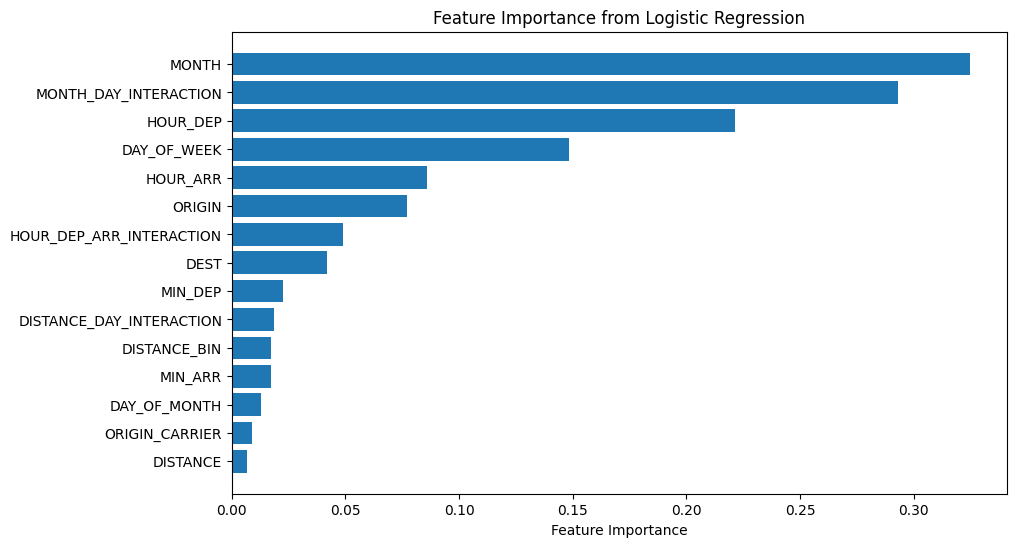

In [ ]:

importance = abs(logreg_model.coef_[0])

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_bal.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

## **Logistic Regression with ADASYN Sampling**

In [ ]:
logreg_model = LogisticRegression()
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(logreg_model, X_bal, y_bal)
performance_metrics("Logistic Regression", avg_metrics)


Logistic Regression Model Performance Metrics


,Metric,Score
0,Accuracy,0.581467
1,Precision,0.581170
2,Recall,0.598691
3,F1 Score,0.589801
4,ROC AUC,0.608821



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,779747,602628
Actual Positive,560519,836209


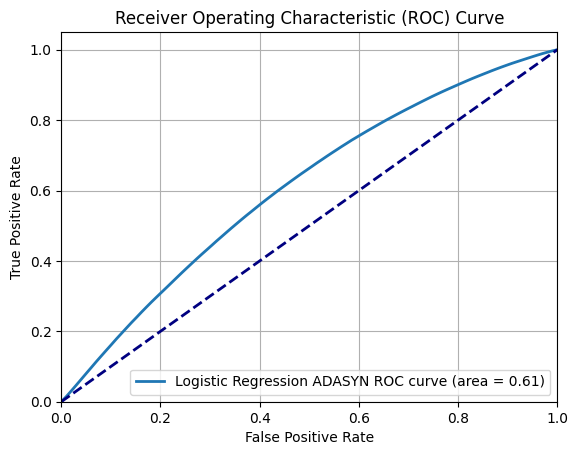

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Logistic Regression ADASYN")

## **Logistic Regression with SMOTE Sampling**

In [ ]:
#Logistic Regression Evaluation
logreg_model = LogisticRegression()
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(logreg_model, X_bal, y_bal)
performance_metrics("Logistic Regression", avg_metrics)


Logistic Regression Model Performance Metrics


,Metric,Score
0,Accuracy,0.595141
1,Precision,0.591945
2,Recall,0.612520
3,F1 Score,0.602057
4,ROC AUC,0.625797



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,798684,583691
Actual Positive,535643,846732


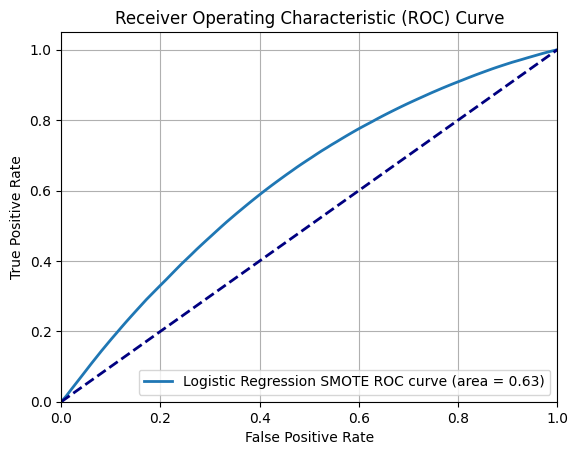

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Logistic Regression SMOTE")

## **Logistic Regression with Random Subsample and downsample**

In [ ]:
#Logistic Regression Evaluation
logreg_model = LogisticRegression()
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(logreg_model, X_bal, y_bal)
performance_metrics("Logistic Regression", avg_metrics)


Logistic Regression Model Performance Metrics


,Metric,Score
0,Accuracy,0.589086
1,Precision,0.578927
2,Recall,0.653484
3,F1 Score,0.613945
4,ROC AUC,0.618329



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,102860,93180
Actual Positive,67931,128109


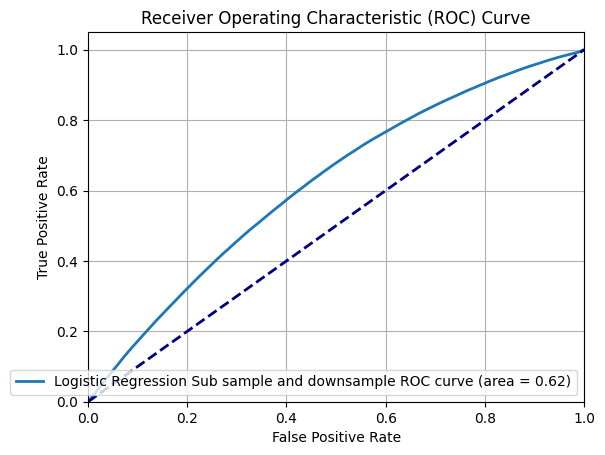

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Logistic Regression Sub sample and downsample")

## **Random Forest**

In [ ]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state=35)
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(rf_model, X_bal, y_bal)
performance_metrics("Random Forest", avg_metrics)


Random Forest Model Performance Metrics


,Metric,Score
0,Accuracy,0.810917
1,Precision,0.815771
2,Recall,0.805743
3,F1 Score,0.810726
4,ROC AUC,0.888644



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,1128219,254156
Actual Positive,271324,1125404


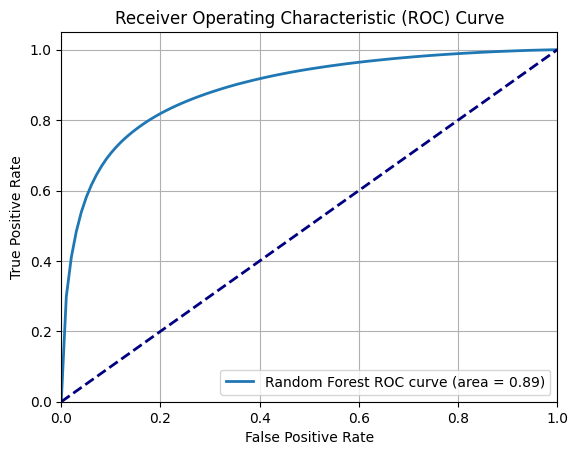

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Random Forest")

# **XGB**

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=35)
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(xgb_model, X_bal, y_bal)
performance_metrics("XGBoost", avg_metrics)


XGBoost Model Performance Metrics


,Metric,Score
0,Accuracy,0.749974
1,Precision,0.793642
2,Recall,0.679091
3,F1 Score,0.731910
4,ROC AUC,0.830068



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,1135750,246625
Actual Positive,448223,948505


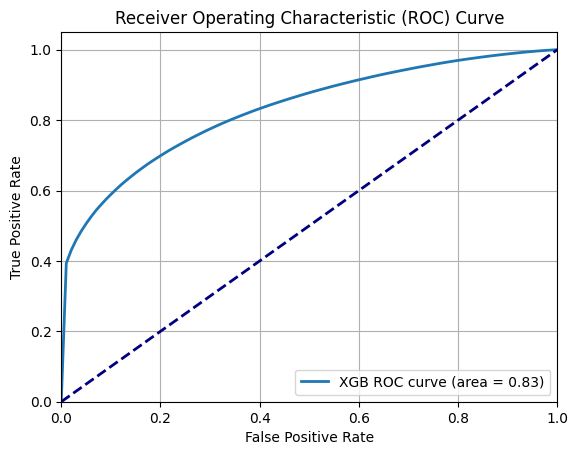

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "XGB")

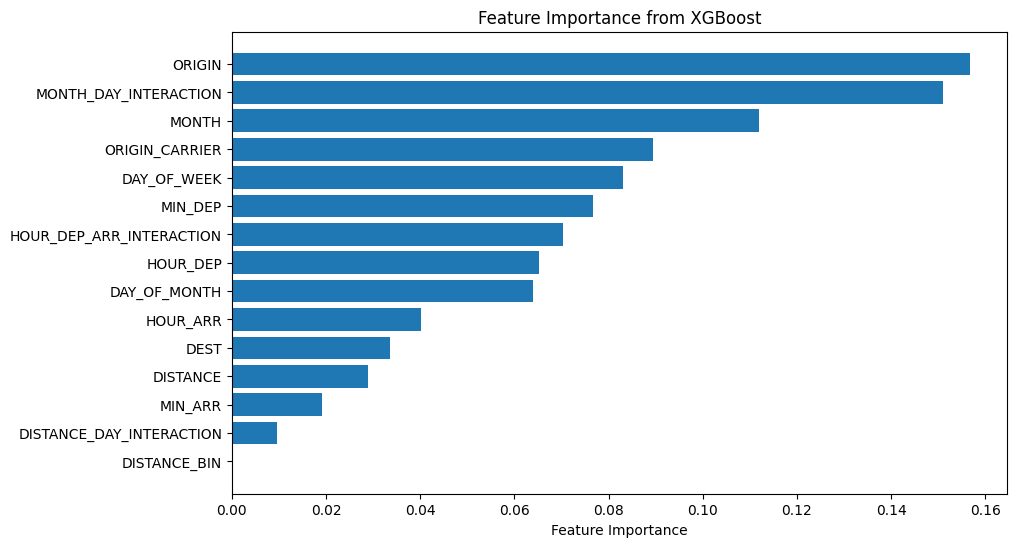

In [ ]:
# Get feature importance
importance = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Sample 10% of the data
X_sample, _, y_sample, _ = train_test_split(X_bal, y_bal, test_size=0.95, random_state=42, stratify=y_bal)

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
}
from sklearn.model_selection import GridSearchCV
# GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, tree_method='hist'),
    param_grid_xgb,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=35),
    scoring='roc_auc',
    n_jobs=1
)

grid_search_xgb.fit(X_sample, y_sample)

# Best Model and Parameters
tuned_xgb_model = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

print(f"Best XGBoost Parameters: {best_params_xgb}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-cf4421dbb8f7>", line 23, in <cell line: 23>
    grid_search_xgb.fit(X_sample, y_sample)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 1422, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 845, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 65, in __call__
    ret

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Evaluate Tuned XGBoost
avg_metrics_tuned_xgb, avg_fpr_tuned_xgb, avg_tpr_tuned_xgb, avg_roc_auc_tuned_xgb = evaluate_model(tuned_xgb_model, X_bal, y_bal)
performance_metrics("Tuned XGBoost", avg_metrics_tuned_xgb)

## **LightGBM with ADASYN**

In [ ]:
lgb_model = lgb.LGBMClassifier()
avg_metrics_lgb, avg_fpr_lgb, avg_tpr_lgb, avg_roc_auc_lgb = evaluate_model(lgb_model, X_bal,y_bal)
performance_metrics("LightGBM", avg_metrics_lgb)

[LightGBM] [Info] Number of positive: 931152, number of negative: 921583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.337254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1852735, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502582 -> initscore=0.010330
[LightGBM] [Info] Start training from score 0.010330
[LightGBM] [Info] Number of positive: 931152, number of negative: 921583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 1852735, number of used features: 15
[LightGBM] [In

,Metric,Score
0,Accuracy,0.723996
1,Precision,0.758120
2,Recall,0.662059
3,F1 Score,0.706841
4,ROC AUC,0.801885



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,1087342,295033
Actual Positive,472011,924717


## **LightGBM with SMOTE**

In [ ]:
lgb_model = lgb.LGBMClassifier()
avg_metrics_lgb, avg_fpr_lgb, avg_tpr_lgb, avg_roc_auc_lgb = evaluate_model(lgb_model, X_bal,y_bal)
performance_metrics("LightGBM", avg_metrics_lgb)

[LightGBM] [Info] Number of positive: 921583, number of negative: 921583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 968
[LightGBM] [Info] Number of data points in the train set: 1843166, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 921584, number of negative: 921583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 1843167, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initsco

,Metric,Score
0,Accuracy,0.724782
1,Precision,0.754829
2,Recall,0.665845
3,F1 Score,0.707548
4,ROC AUC,0.801868



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,1083393,298982
Actual Positive,461928,920447


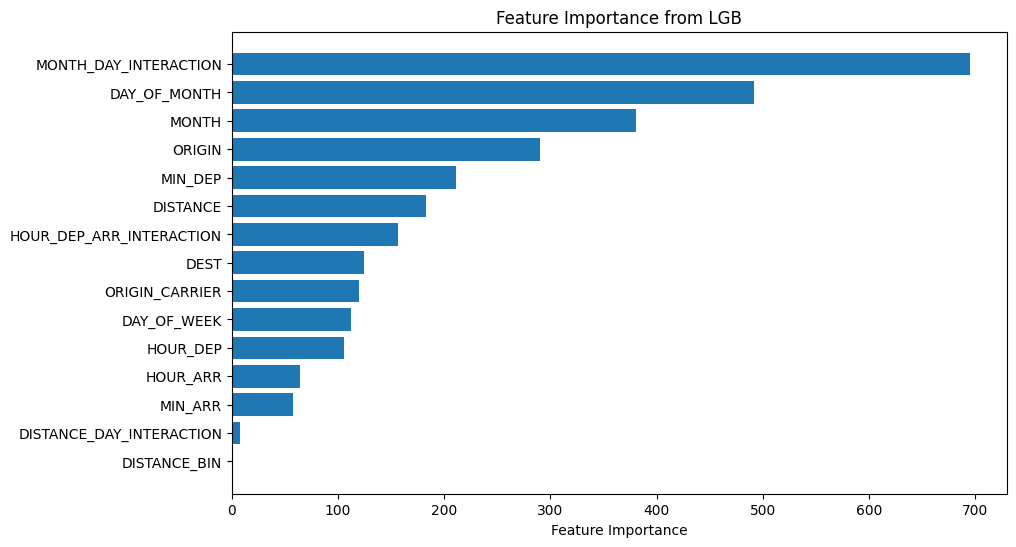

In [ ]:
# Get feature importance
importance = lgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from LGB')
plt.gca().invert_yaxis()
plt.show()

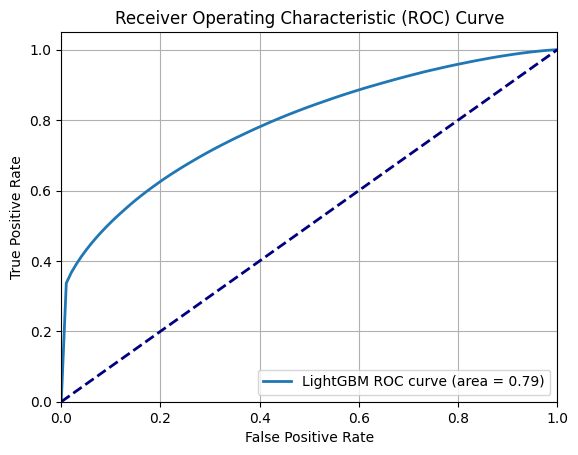

In [ ]:
plot_roc_curve(avg_fpr_lgb, avg_tpr_lgb, avg_roc_auc_lgb, "LightGBM")

## **MLP**

In [ ]:

mlp_model = mlp(random_state=42)
avg_metrics_mlp, avg_fpr_mlp, avg_tpr_mlp, avg_roc_auc_mlp = evaluate_model(mlp_model, X_bal, y_bal)
performance_metrics("MLP", avg_metrics_mlp)

In [ ]:
plot_roc_curve(avg_fpr_mlp, avg_tpr_mlp, avg_roc_auc_mlp, "MLP")

## **Cat Boost**

In [ ]:

catboost_model = cat.CatBoostClassifier()
avg_metrics_cat, avg_fpr_cat, avg_tpr_cat, avg_roc_auc_cat = evaluate_model(catboost_model, X_bal, y_bal)
performance_metrics("CatBoost", avg_metrics_cat)


Learning rate set to 0.25603
0:	learn: 0.6810290	total: 563ms	remaining: 9m 22s
1:	learn: 0.6717692	total: 997ms	remaining: 8m 17s
2:	learn: 0.6627777	total: 1.42s	remaining: 7m 51s
3:	learn: 0.6581395	total: 1.81s	remaining: 7m 31s
4:	learn: 0.6540041	total: 2.21s	remaining: 7m 19s
5:	learn: 0.6476260	total: 2.67s	remaining: 7m 22s
6:	learn: 0.6451186	total: 3.06s	remaining: 7m 13s
7:	learn: 0.6434370	total: 3.42s	remaining: 7m 4s
8:	learn: 0.6381517	total: 3.87s	remaining: 7m 5s
9:	learn: 0.6306199	total: 4.29s	remaining: 7m 4s
10:	learn: 0.6289937	total: 4.7s	remaining: 7m 2s
11:	learn: 0.6252084	total: 5.14s	remaining: 7m 3s
12:	learn: 0.6225930	total: 5.57s	remaining: 7m 2s
13:	learn: 0.6166399	total: 5.99s	remaining: 7m 2s
14:	learn: 0.6127685	total: 6.38s	remaining: 6m 59s
15:	learn: 0.6108929	total: 6.82s	remaining: 6m 59s
16:	learn: 0.6073614	total: 7.2s	remaining: 6m 56s
17:	learn: 0.6032153	total: 7.62s	remaining: 6m 55s
18:	learn: 0.5992594	total: 8.05s	remaining: 6m 55s
19

,Metric,Score
0,Accuracy,0.797905
1,Precision,0.881077
2,Recall,0.691180
3,F1 Score,0.774660
4,ROC AUC,0.873602



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,1252068,130307
Actual Positive,431337,965391


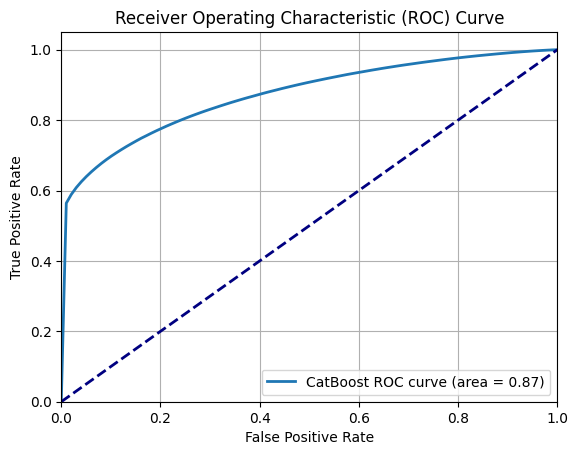

In [ ]:
plot_roc_curve(avg_fpr_cat, avg_tpr_cat, avg_roc_auc_cat, "CatBoost")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Sample 10% of the data
X_sample, _, y_sample, _ = train_test_split(X_bal, y_bal, test_size=0.95, random_state=42, stratify=y_bal)

# Parameter grid for CatBoost
param_dist_catboost = {
    'depth': [5, 7],
    'learning_rate': [0.01, 0.001],
    'subsample': [0.7, 1],
    'l2_leaf_reg': [3, 5],
    'border_count': [32, 50],
    'iterations': [100, 200]
}

# Initialize CatBoostClassifier
catboost_model = cat.CatBoostClassifier(random_seed=42, silent=True)

# RandomizedSearchCV for CatBoost
random_search_catboost = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist_catboost,
    n_iter=10,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=35),
    scoring='roc_auc',
    n_jobs=1,
    random_state=42
)


random_search_catboost.fit(X_sample, y_sample)

# Best Model and Parameters
tuned_catboost_model = random_search_catboost.best_estimator_
best_params_catboost = random_search_catboost.best_params_

print(f"Best CatBoost Parameters: {best_params_catboost}")

Best CatBoost Parameters: {'subsample': 1, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 7, 'border_count': 50}


## **Tuned CatBoost Model**

In [ ]:
catboost_model = cat.CatBoostClassifier(
    subsample=1,
    learning_rate=0.01,
    l2_leaf_reg=5,
    iterations=200,
    depth=7,
    border_count=50,
    verbose=0
)
avg_metrics_cat, avg_fpr_cat, avg_tpr_cat, avg_roc_auc_cat = evaluate_model(catboost_model, X_bal, y_bal)
performance_metrics("CatBoost", avg_metrics_cat)


CatBoost Model Performance Metrics


,Metric,Score
0,Accuracy,0.645504
1,Precision,0.646043
2,Recall,0.651731
3,F1 Score,0.648873
4,ROC AUC,0.708070



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,883632,498743
Actual Positive,486437,910291


In [ ]:
catboost_model = cat.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    l2_leaf_reg=3.0,
    border_count=50,
    subsample=1.0,
    random_seed=42,
    verbose=0
)
avg_metrics_cat, avg_fpr_cat, avg_tpr_cat, avg_roc_auc_cat = evaluate_model(catboost_model, X_bal, y_bal)
performance_metrics("CatBoost", avg_metrics_cat)


CatBoost Model Performance Metrics


,Metric,Score
0,Accuracy,0.810447
1,Precision,0.895437
2,Recall,0.705190
3,F1 Score,0.789007
4,ROC AUC,0.886188



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,1267357,115018
Actual Positive,411770,984958


### **Testing on Unseen January 2024 to June 2024 data**

In [ ]:
# unseen Test data
test_file_path = '/content/drive/My Drive/2024_FLIGHT/FLIGHT/dataset_13.csv'
test_df = pd.read_csv(test_file_path)

In [ ]:
print(test_df.isna().sum())

YEAR                 0
QUARTER              0
MONTH                0
DAY_OF_MONTH         0
FL_DATE              0
ORIGIN_AIRPORT_ID    0
ORIGIN               0
DEST_AIRPORT_ID      0
DEST                 0
DISTANCE             0
ORIGIN_CARRIER       0
CRS_DEP_TIME         0
DEP_TIME             0
DEP_DELAY_NEW        0
DEP_DEL15            0
CRS_ARR_TIME         0
ARR_TIME             0
ARR_DELAY_NEW        0
ARR_DEL15            0
dtype: int64


In [ ]:
test_df.shape

(458434, 19)

In [ ]:
# Drop unnecessary columns
test_df = drop_cols(test_df)

In [ ]:
# Apply feature engineering
test_df = feature_engineering(test_df)

In [ ]:
# Split the test data into features (X) and target (y)
X_test = test_df.drop('ARR_DEL15', axis=1)
y_test = test_df['ARR_DEL15']


In [ ]:
# Make predictions on the remaining 90% of the test data
y_pred = catboost_model.predict(X_test)

# Compute class-weighted metrics
y_test_weights = np.array([3 if y == 0 else 2 for y in y_test])
accuracy = accuracy_score(y_test, y_pred, sample_weight=y_test_weights)
print("Weighted Accuracy:", accuracy)

# Compute other metrics that are less sensitive to class imbalance
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Weighted Accuracy: 0.8045791229101312
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.96      0.85    304554
         1.0       0.57      0.16      0.25    108037

    accuracy                           0.75    412591
   macro avg       0.67      0.56      0.55    412591
weighted avg       0.71      0.75      0.69    412591

ROC AUC Score: 0.5587491152123338
